<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

<h1> K-means clustering </h1>

<h2>1. Theory</h2>

Given $M$ data in an $N$-dimensional space, we want to group the data in $K$ clusters. As per usual we define an error metric which we want to minimize during the optimization process which, in this case, is the process of assigning the affinity to a specific cluster for each data point.

We define the cost function to be

\begin{align}\tag{1}
J(r,\mu) = \sum_{m=1}^{M}\sum_{k=1}^{K} r_{mk} ||X_{mn} - \mu_{kn}||^2,
\end{align}

where $X\in\mathbb{R}^{M\times N}$ is the design matrix, where each row is a vector in $\mathbb{R}^N$ and represents a data point, $\mu\in\mathbb{R}^{K\times N}$ is the cluster matrix where its rows are also vectors in $\mathbb{R}^N$ and represent the centroid of the $K$ clusters, and $r\in\mathbb{N}^{M\times K}$ is the assignment matrix. Each row of $r$ is a vector in $\mathbb{N}^K$ which represents the cluster assignment to the data point $m$; each element of the assignment matrix assumes values $r_{mk}\in\{0,1\}$.


The clustering algorithm is an iterative procedure which consists of two basic steps:
<ul>
<li>Expectation (E) step: given the cluster matrix $\mu$, for each one of the $M$ data points $x_m$ calculate the distances $d_{mk} = ||x_m-\mu_{k}||^2$ with respect to the $K$ clusters. Then assign each point to the cluster with the closest centroid by updating the assignment matrix $r$. </li>
</ul>
<ul><li>Maximization (M) step: update the cluster matrix $\mu$ by minimizing the cost function with respect to the centroids, i.e.</li>
</ul>

\begin{align}\tag{2}
\frac{\partial J(r,\mu)}{\partial\mu_{jn}} = -2\sum_{m=1}^{M}\sum_{k=1}^{K} r_{mk} \left(X_{mn} - \mu_{kn}\right)\delta_{kj} = -2\sum_{m=1}^{M}r_{mj} \left(X_{mn} - \mu_{jn}\right) = 0,
\end{align}

<ul style="list-style: none;"><li>and if we solve for $\mu$ we get</li>
</ul>

\begin{align}\tag{3}
\mu_{kn} = \frac{\sum_{m=1}^M r_{mk}X_{mn}}{\sum_{m=1}^Mr_{mk}},
\end{align}

<ul style="list-style: none;"><li>which is the update rule we have to use.</li>
</ul>

<h2> 2. Python implementation </h2>

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Function to normalize data
def normalize_data(df):
    # Number of columns
    header = df.columns.values
    # Normalize column by column
    for col in header:
        cmax = np.max(df[col])
        cmin = np.min(df[col])
        if ((cmax - cmin) != 0.0 and cmax != 0.0 and cmin != 0.0):
            df[col] = df[col].apply(lambda r: float(r - cmin)/float(cmax - cmin))
    return df

class KmeansModel:
    # Initialization
    def __init__(self,df,clusters=1,seed=586,seeding='standard'):
        np.random.seed(seed)
        # Number of data samples and space dimension
        self.M, self.N = df.shape
        # Initialize design matrix
        self.X = np.matrix(df)
        # Initialize cluster assignment matrix
        self.K = K
        self.r = np.zeros((self.M,self.K),dtype = int)
        for i in range(self.M):
            idx = np.random.randint(0,self.K)
            self.r[i,idx] = 1 # random cluster assignment
        # Initialize cluster matrix
        if (seeding == 'standard'):
            self.mu = np.random.rand(self.K,self.N)
        elif (seeding == '++'):
            self._chooseRandom()
            self._selectCentroid()
        # Cost
        self.J_final = 0.0
        return
    
    # Expectation step: minimize the cost with respect to rnk
    # Basically, assign the points to the closest cluster centroid
    # so that we minimize the cost
    def _expectation(self):
         # Calculate square distance, each column of the dist
        # matrix represents the distance to the k-th centroid
        dist = np.zeros((self.M,self.K),dtype=float)
        for k in range(self.K):
            dist[:,k] = np.square(self.X - self.mu[k,:]).sum(axis=1).reshape(self.M)
        # Update labels to account for closest centroid
        self.r.fill(0)
        for idx in range(self.M):
            self.r[idx,np.argmin(dist[idx,:])] = 1 
        return

    # Maximization step: adjust the clusters centroids positions to
    # maximize the cost
    def _maximization(self):
        self.mu = np.dot(np.transpose(self.r),self.X)
        for k in range(self.K):
            self.mu[k,:] = self.mu[k,:] / np.sum(self.r[:,k])
        return

    # Cost function J
    def _getCost(self):
        J = 0.0
        for k in range(self.K):
            for m in range(self.M):
                J += self.r[m,k] * np.linalg.norm(self.X[m,:] - self.mu[k,:])
        return J
    
    # Step 1 of Kmeans++ (see section 4)
    # Choose random centroids from the data
    def _chooseRandom(self):
        self.mu = np.zeros((self.K,self.N),dtype = float)
        for k in range(self.K):
            idx = np.random.randint(0,self.M)
            self.mu[k,:] = self.X[idx, :]
        return
    
    # Step 2 and 3 of Kmeans++ (see section 4)
    # Calculate distance from nearest centroid for each point,
    # return squared distance normalized (as probability)
    def _getPdistSquare(self):
        # Calculate distances from each centroid
        dist = np.zeros((self.M,self.K),dtype=float)
        for k in range(self.K):
            dist[:,k] = np.square(self.X - self.mu[k,:]).sum(axis=1).reshape(self.M)
        # Find list of minimum distances
        dist_min = np.min(dist,axis=1)
        # Square
        dist_min = dist_min ** 2
        # Normalize
        dist_min = dist_min / np.sum(dist_min)
        return dist_min
    
    # Step 4 of Kmeans++ (see section 4)
    # Select iteratively the centroids
    def _selectCentroid(self):
        for k in range(self.K):
            dist2 = self._getPdistSquare()
            idx = np.random.choice(self.M,p=dist2)
            self.mu[k,:] = self.X[idx,:]
        return
        
    # Run the Kmeans for a certain number of iterations or
    # until we reach convergence, i.e. when the centroids and 
    # assignments do not change anymore
    def solve(self,maxIter=10,tolerance=1E-10):
        convergence = False
        it = 0
        while ((not convergence) and (it != maxIter)):
            # Initial cost
            J_old = self._getCost()
            # Expectation step
            self._expectation()
            # Maximization step
            self._maximization()
            # New cost
            J_new = self._getCost()
            # Check convergence
            deltaJ = np.abs(J_new - J_old)
            if (deltaJ < tolerance):
                convergence = True
            it += 1
            # Save new cost
            J_old = J_new
            print ("Iteration " + str(it) + " ** Cost = " + str(J_new))
        self.J_final = J_new
        return

<h2> 3. Clustering on 2d test set </h2>

Here we test K-means clustering using the <a href="http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat">old faithful dataset</a>.

In [2]:
# Import libraries
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

# Useful functions to plot the data
def plot_faithful(X,r,mu,cost=""):
    fig = figure()
    sub = fig.add_subplot(111)
    
    sub.scatter(np.array(X[:,0]),np.array(X[:,1]),c=np.array(r[:,1]),alpha=0.5)
    sub.set_xlabel('eruptions')
    sub.set_ylabel('waiting')
    sub.scatter(np.array(mu[:,0]),np.array(mu[:,1]),color='black')
    sub.set_title(cost)
    
    plt.show()
    
    return

In [3]:
# Import dataset and drop firs column (index column)
df = pd.read_csv("../DATASETS/faithful.csv")
df.drop(df.columns[[0]],axis=1,inplace=True)
print (df.head(3))

   eruptions  waiting
0      3.600       79
1      1.800       54
2      3.333       74


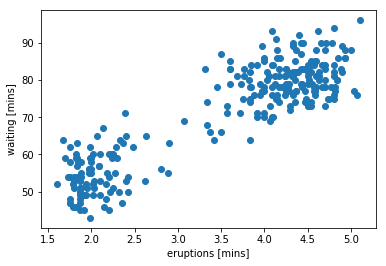

In [4]:
# Visualize data
fig = figure()
sub = fig.add_subplot(111)

sub.scatter(df.eruptions,df.waiting)
sub.set_xlabel('eruptions [mins]')
sub.set_ylabel('waiting [mins]')

plt.show()

In [5]:
# Normalize data
df = normalize_data(df)
# Set number of clusters
K = 2
# Initialize K-means model
km = KmeansModel(df,K)

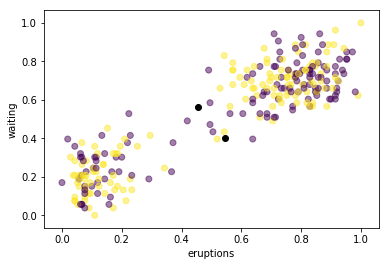

In [6]:
# Let's visualize the data with different colors 
# for the different clusters, in yellow we have
# the positions of the centroids
plot_faithful(km.X,km.r,km.mu)

In [7]:
# Run Kmeans
km.solve()

Iteration 1 ** Cost = 89.2630334052
Iteration 2 ** Cost = 36.9756838768
Iteration 3 ** Cost = 36.2363328096
Iteration 4 ** Cost = 36.2363328096


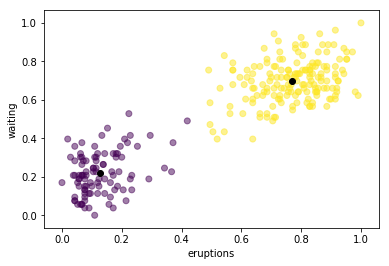

In [8]:
# Plot the data with the final cluster assignments
plot_faithful(km.X,km.r,km.mu)

<h2> 4. K-means++ </h2>

The clusters obtained with the K-means algorithm highly depend on the initial choice of the centroids and the performance can vary a lot depending on where we choose to put the initial values of these centroids. For example let's choos manually the centroids so that they are very close together and far from the data: 

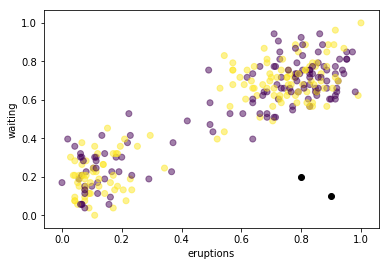

In [9]:
# Initialize matrices for K-means clustering algorithm
km = KmeansModel(df,K)
# Set first centroid manually
km.mu[0,0] = 0.8
km.mu[0,1] = 0.2
# Set second centroid manually
km.mu[1,0] = 0.9
km.mu[1,1] = 0.1
# Plot initial positions of centroids 
plot_faithful(km.X,km.r,km.mu)

We don't even need to run K-means to know what is going to happen. If we look at the positions of the two centroids, we see that already at the first assignment of labels to the points, all the data will belong to the same cluster.Indeed, if we run K-means with a single iteration we can see the problem:

Iteration 1 ** Cost = nan


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in absolute


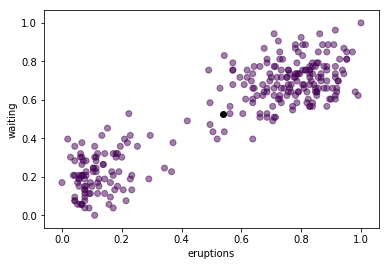

In [10]:
km.solve(maxIter=1)
plot_faithful(km.X,km.r,km.mu)

It is clear we need a good way to initialize the centroids, especially because with multi-dimensional data or when we have many clusters, the problem will be even more pronounced. There's different methods that can be used to alleviate this problem, but here we will use a method called <a href="https://en.wikipedia.org/wiki/K-means%2B%2B">K-means++</a>, first proposed by in 2006 by David Arthur and Sergei Vassilvitski (Ref. <a href="http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf">k-means++: The Advantages of Careful Seeding</a>).

The initial choice of the centroids is performed as follows:

<ul><li>Choose one center uniformly at random from among the data points.</li></ul>

<ul><li>For each data point $x_m$, compute $d_{min}(x_m)$, the distance between $x_m$ and the nearest center $\mu_k$ that has already been chosen.</li></ul>

<ul><li>Choose one new data point at random as a new center, using a weighted probability distribution where a point $x_m$ is chosen with probability proportional to $d_{min}^2(x_m)$</li></ul>

<ul><li>Repeat Steps 2 and 3 until $K$ centers have been chosen.</li></ul>

<ul><li>Now that the initial centers have been chosen, proceed using standard K-means clustering.</li></ul>

The seeding functions for the K-means++ algorithm are already implemented in our K-means model class, we just need to choose the seeding when initializing our model. Let's try this new seeding procedure and plot the initial positions of the clusters.

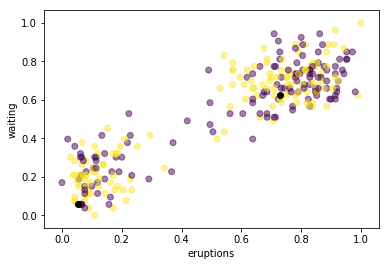

In [11]:
kmpp = KmeansModel(df,K,seeding='++')
plot_faithful(kmpp.X,kmpp.r,kmpp.mu)

The initial positions of the centroids are now much better!!! Let's finish by running the normal clustering algorithm now.

Iteration 1 ** Cost = 36.4358585681
Iteration 2 ** Cost = 36.2230805399
Iteration 3 ** Cost = 36.2363328096
Iteration 4 ** Cost = 36.2363328096


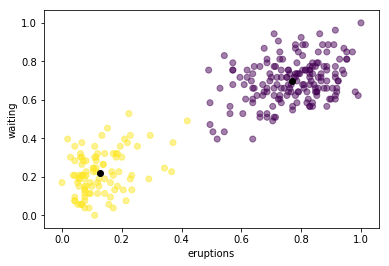

In [12]:
kmpp.solve()
plot_faithful(kmpp.X,kmpp.r,kmpp.mu)